In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import operator
import orjson as json

## Decision Tree class implementation

In [16]:
class DecisionTree:
    def __init__(self):
        self.tree = None
        self.features = list
        self.XTrain = np.array
        self.yTrain = np.array
        self.num_feats = int
        self.train_size = int
        self.nodes = 0

    def split_table(self, df, feature, pivot, operation):
        return df[operation(df[feature], pivot)].reset_index(drop=True)

    def fit(self, X, y):
        self.XTrain = X
        self.yTrain = y
        self.features = list(X.columns)
        self.train_size = X.shape[0]
        self.num_feats = X.shape[1]

        df = X.copy()
        df['category'] = y.copy()

        self.tree = self.make_subtree(df)
        s = str(self.tree)
        s = s.replace("\'", "\"")
        json_object = json.loads(s)
        print(json.dumps(json_object, option=json.OPT_INDENT_2).decode())

    def make_subtree(self, df, tree=None):
        feature, cutoff, igrmax = self.calc_feature_info(df)
        categories, count = np.unique(df['category'], return_counts=True)
        # print(f"Chosen {feature} with cutoff {cutoff}, Base node has {categories} with count {count}")
        if tree is None:
            tree = {feature: {}}
        if cutoff == None:
          tree[feature]['>=' + str(-1.5) + ' then'] = 1
          return tree
        
        self.nodes +=1  

        # Left Child
        new_df = self.split_table(df, feature, cutoff, operator.ge)
        categories, count = np.unique(new_df['category'], return_counts=True)
        # print(f"LEFT node has {categories} with count {count}")
        if len(count) == 1:  # all are same category
            tree[feature]['>=' + str(cutoff) + ' then'] = categories[0]
        else:
            tree[feature]['>=' + str(cutoff) + ' then'] = self.make_subtree(new_df)

        # Right Child
        new_df = self.split_table(df, feature, cutoff, operator.lt)
        categories, count = np.unique(new_df['category'], return_counts=True)
        # print(f"RIGHT node has {categories} with count {count}")
        if len(count) == 1:  # all are same category
            tree[feature]['else ' + '<' + str(cutoff)] = categories[0]
        else:
            tree[feature]['else ' + '<' + str(cutoff)] = self.make_subtree(new_df)

        return tree

    def entropy(self, df):
        entropy = 0
        for target in df['category'].unique():
            probability = df['category'].value_counts()[target] / len(df['category'])
            if probability>0:
                entropy -= probability * np.log2(probability)

        return entropy
    
    def calc_feature_info(self, df):
        ent_base = self.entropy(df)
        features = df.columns[:-1]
        datalen = len(df)

        max_info_gain_ratio = 0
        threshold = None
        chosen_feat = features[0]
        for feature in features:
            candid_points = sorted(df[feature].unique())
            for can_point in candid_points:
                total_ent = 0
                ent_weight = 0
                for op in [operator.lt,operator.ge]:
                    split_ = self.split_table(df, feature, can_point, op)

                    if len(split_)>0:
                        ent_ = self.entropy(split_)
                        total_ent += len(split_)*ent_/datalen
                        ent_weight += (len(split_)/datalen)*np.log2(datalen/len(split_))
                
                info_gain_ratio = (ent_base-total_ent)/ent_weight if ent_weight>0 else 0
                if info_gain_ratio>max_info_gain_ratio:
                    max_info_gain_ratio = info_gain_ratio
                    threshold = can_point
                    chosen_feat = feature
                # print(feature, can_point, info_gain_ratio, chosen_feat)

        return chosen_feat, threshold, max_info_gain_ratio

    def predict(self, X):
        results = []

        for i in range(len(X)):
            results.append(self.predict_X(X.iloc[i], self.tree))

        return np.array(results)

    def predict_X(self, x, tree):
        node = list(tree.keys())[0]
        val = x[node]
        cutoff = list(tree[node].keys())[0].split('>=')[1].split(' ')[0]

        if val >= float(cutoff):  # Left Child
            tree = tree[node]['>=' + cutoff + ' then']
        else:  # Right Child
            tree = tree[node]['else ' + '<' + cutoff]

        if type(tree) is dict:
            return self.predict_X(x, tree)
        else:
            return tree


## Question 4

In [17]:
data_d3 = pd.read_table("data/D3leaves.txt", sep=" ", header=None, names=["X1", "X2", "Y"])
cols = list(data_d3.columns)
X, y = data_d3.loc[:,cols[:-1]], data_d3.loc[:,cols[-1]]
dt_clf_d3 = DecisionTree()
dt_clf_d3.fit(X, y)

{
  "X1": {
    ">=10 then": 1,
    "else <10": {
      "X2": {
        ">=3 then": 1,
        "else <3": 0
      }
    }
  }
}


## Question 5

### Building the tree for `D1.txt`

In [18]:
data_d1 = pd.read_table("data/D1.txt", sep=" ", header=None, names=["X1", "X2", "Y"])
cols = list(data_d1.columns)
X_d1, y_d1 = data_d1.loc[:,cols[:-1]], data_d1.loc[:,cols[-1]]
dt_clf_d1 = DecisionTree()
dt_clf_d1.fit(X_d1, y_d1)

{
  "X2": {
    ">=0.201829 then": 1,
    "else <0.201829": 0
  }
}


### Building the tree for `D2.txt`

In [19]:
data_d2 = pd.read_table("data/D2.txt", sep=" ", header=None, names=["X1", "X2", "Y"])
cols = list(data_d2.columns)
X_d2, y_d2 = data_d2.loc[:,cols[:-1]], data_d2.loc[:,cols[-1]]
dt_clf_d2 = DecisionTree()
dt_clf_d2.fit(X_d2, y_d2)

{
  "X1": {
    ">=0.533076 then": {
      "X2": {
        ">=0.228007 then": {
          "X2": {
            ">=0.424906 then": 1,
            "else <0.424906": {
              "X1": {
                ">=0.708127 then": 1,
                "else <0.708127": {
                  "X2": {
                    ">=0.32625 then": {
                      "X1": {
                        ">=0.595471 then": {
                          "X1": {
                            ">=0.646007 then": 1,
                            "else <0.646007": {
                              "X2": {
                                ">=0.403494 then": 1,
                                "else <0.403494": 0
                              }
                            }
                          }
                        },
                        "else <0.595471": 0
                      }
                    },
                    "else <0.32625": 0
                  }
                }
              }
            }
        

## Question 6

### Plotting the dataset
#### `D1.txt`

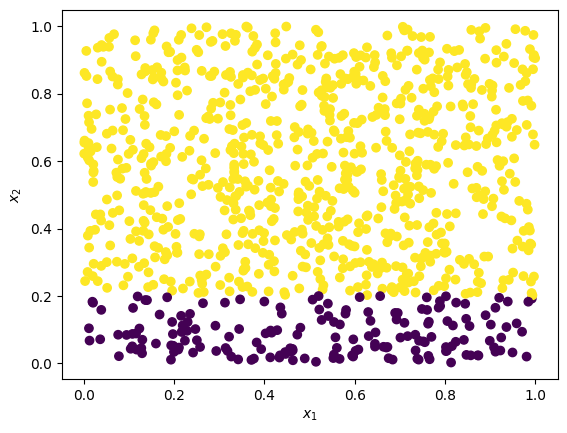

In [20]:
plt.scatter(X_d1["X1"],X_d1["X2"], c=y_d1)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

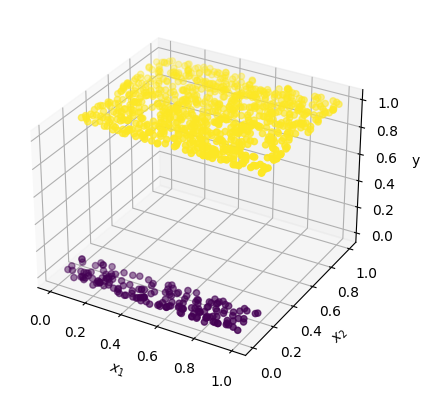

In [21]:
fig = plt.figure()
projection = fig.add_subplot(projection='3d')
projection.scatter(X_d1["X1"], X_d1["X2"], y_d1, c=y_d1)
projection.set_xlabel("$x_1$")
projection.set_ylabel("$x_2$")
projection.set_zlabel("y")
plt.show()

`D2.txt`

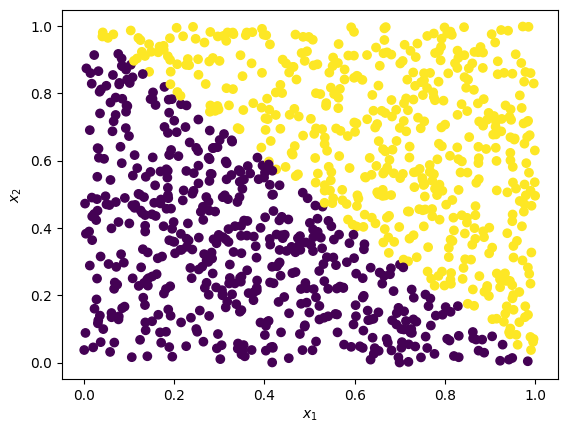

In [22]:
plt.scatter(X_d2["X1"], X_d2["X2"], c=y_d2)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

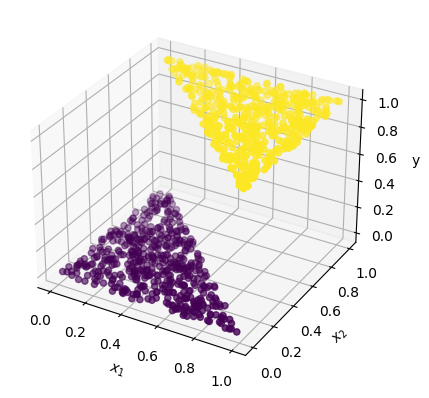

In [23]:
fig = plt.figure()
projection = fig.add_subplot(projection='3d')
projection.scatter(X_d2["X1"], X_d2["X2"], y_d2, c=y_d2)
projection.set_xlabel("$x_1$")
projection.set_ylabel("$x_2$")
projection.set_zlabel("y")
plt.show()

### Plotting the decision boundary

In [24]:
X = np.mgrid[0:1:0.02,0:1:0.02].reshape(2,-1)
X = pd.DataFrame(X.T)
X.columns = ["X1","X2"]

`D1.txt`

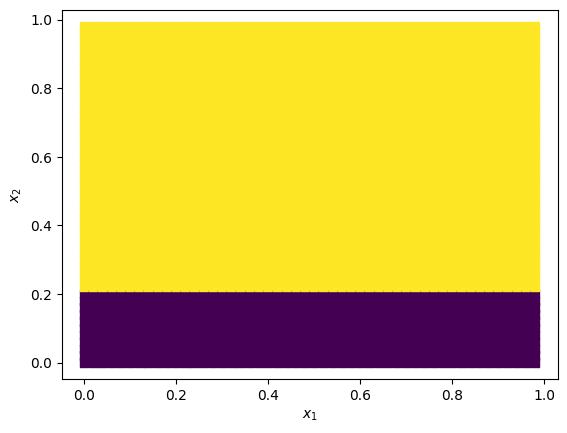

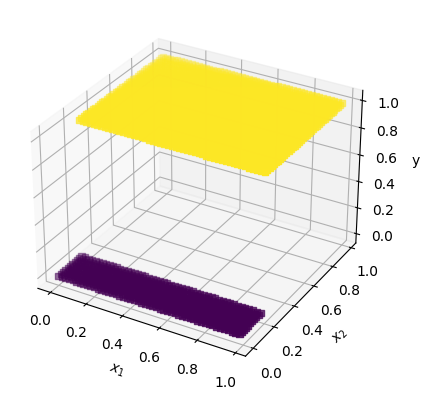

In [25]:
Y_pred = dt_clf_d1.predict(X)
plt.scatter(X["X1"], X["X2"], c=Y_pred, marker='s')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

fig = plt.figure()
projection = fig.add_subplot(projection='3d')
projection.scatter(X["X1"], X["X2"], Y_pred, c=Y_pred, marker='s')
projection.set_xlabel("$x_1$")
projection.set_ylabel("$x_2$")
projection.set_zlabel("y")
plt.show()

`D2.txt`

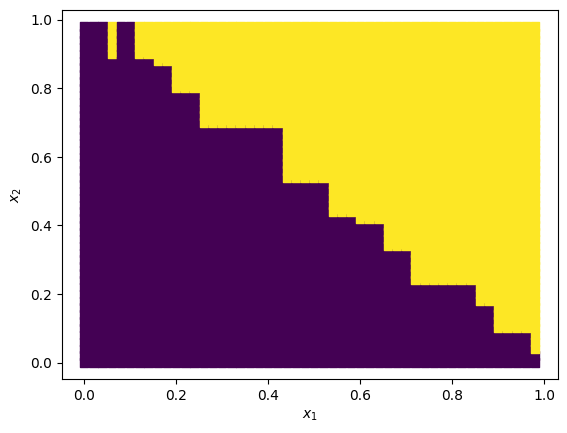

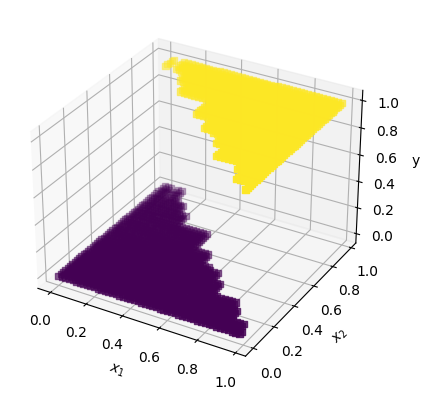

In [26]:
Y_pred = dt_clf_d2.predict(X)

plt.scatter(X["X1"], X["X2"], c=Y_pred, marker='s')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

fig = plt.figure()
projection = fig.add_subplot(projection='3d')
projection.scatter(X["X1"], X["X2"], Y_pred, c=Y_pred, marker='s')
projection.set_xlabel("$x_1$")
projection.set_ylabel("$x_2$")
projection.set_zlabel("y")
plt.show()